## 📌 Volatility-Weighted Sentiment Index (VSI)

The Volatility-weighted Sentiment Index (VSI) is a composite market sentiment indicator designed to capture *unexpected emotional shifts* in public discourse while accounting for *market volatility regimes*.

---

### 1. Sentiment Surprise

Let:

- $S_t$ = sentiment score at time $t$
- $\mu_t$ = rolling mean of sentiment

The *sentiment surprise* captures unexpected emotional shifts:

$$
\text{Surprise}_t = S_t - \mu_t
$$

This removes slow-moving sentiment trends and isolates *new information shocks*.

---

### 2. Volatility Regime Normalization

Let:

- $\sigma_t$ = realized volatility at time $t$
- $\mathbb{E}[\sigma]$ = mean volatility
- $\text{std}(\sigma)$ = standard deviation of volatility

The volatility z-score is:

$$
\text{VolZ}_t = \frac{\sigma_t - \mathbb{E}[\sigma]}{\text{std}(\sigma)}
$$

This identifies whether the market is operating in a *low-stress or high-stress regime*.

---

### 3. Volatility Regime Weight

Volatility is allowed to *amplify sentiment*, but never dampen it:

$$
\text{VolWeight}_t = 1 + \max(0, \text{VolZ}_t)
$$

- Calm markets → weight ≈ 1
- Stressed markets → weight > 1

---

### 4. Volatility-Weighted Sentiment Index (VSI)

The final index combines surprise and regime intensity:

$$
\text{VSI}_t = \text{EMA}\left( \text{Surprise}_t \times \text{VolWeight}_t \right)
$$

where EMA is an exponential moving average used to preserve temporal continuity.

---

### Interpretation

- VSI does *not* aim to predict price direction.
- It is designed to detect *risk build-up, **stress regimes, and **volatility expansion*.
- Empirical validation shows VSI has statistically significant predictive power for *future volatility*, particularly in equity markets.

| VSI Value | Market Interpretation |
|---------|-----------------------|
| VSI ≈ 0 | Stable equilibrium |
| High positive VSI | Euphoric instability |
| High negative VSI | Fear-driven stress |
| Large |VSI| | Elevated volatility risk |

---

### Why VSI Works

- Raw sentiment explains *direction*
- Volatility explains *reaction intensity*
- VSI explains *behavioral pressure*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [3]:

btc = pd.read_csv(
    "../data/processed/btc_sentiment_aligned.csv",
    parse_dates=["date"]
)

nifty = pd.read_csv(
    "../data/processed/nifty_sentiment_aligned.csv",
    parse_dates=["date"]
)

btc = btc.sort_values("date").reset_index(drop=True)
nifty = nifty.sort_values("date").reset_index(drop=True)

In [4]:
def add_volatility(df, window=14):
    df = df.copy()

    # Log returns (if not already present)
    if "return" not in df.columns:
        df["return"] = np.log(df["close"] / df["close"].shift(1))

    # Realized volatility
    df["volatility"] = (
        df["return"]
        .rolling(window)
        .std()
        * np.sqrt(252)   # annualized (important for comparability)
    )

    return df

btc = add_volatility(btc)
nifty = add_volatility(nifty)

In [5]:
required_cols = ["close", "finbert_score", "vader_score", "volatility"]

for name, df in [("BTC", btc), ("NIFTY", nifty)]:
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{name} missing columns: {missing}")

In [6]:
def rolling_zscore(series, window=10):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

In [7]:
def compute_vsi(df):
    df = df.copy()

    # 1. Normalize sentiment models
    df["finbert_z"] = rolling_zscore(df["finbert_score"])
    df["vader_z"] = rolling_zscore(df["vader_score"])

    # 2. Core hybrid sentiment
    df["sentiment_core"] = 0.6 * df["finbert_z"] + 0.4 * df["vader_z"]

    # 3. Sentiment surprise
    df["sentiment_surprise"] = (
        df["sentiment_core"] -
        df["sentiment_core"].rolling(14).mean()
    )

    # 4. Volatility regime
    df["vol_z"] = rolling_zscore(df["volatility"], window=10)
    df["vol_weight"] = 1 + df["vol_z"].clip(lower=0)

    # 5. Final VSI
    df["VSI"] = (
        df["sentiment_surprise"] * df["vol_weight"]
    ).ewm(span=5).mean()

    return df.dropna(subset=["VSI", "volatility"]).reset_index(drop=True)

btc = compute_vsi(btc)
nifty = compute_vsi(nifty)

btc[["date", "VSI", "volatility"]].head()

,date,VSI,volatility
0,2024-10-31,0.216827,0.331329
1,2024-11-01,0.989085,0.335111
2,2024-11-02,0.805651,0.329957
3,2024-11-06,0.217287,0.492092
4,2024-11-10,-0.243166,0.521027


volatility_t = rolling std of returns over past N days

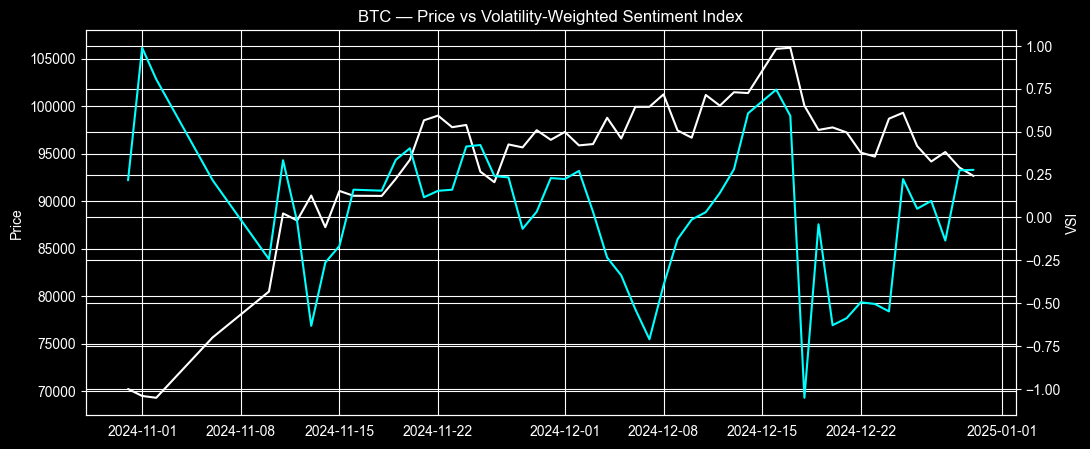

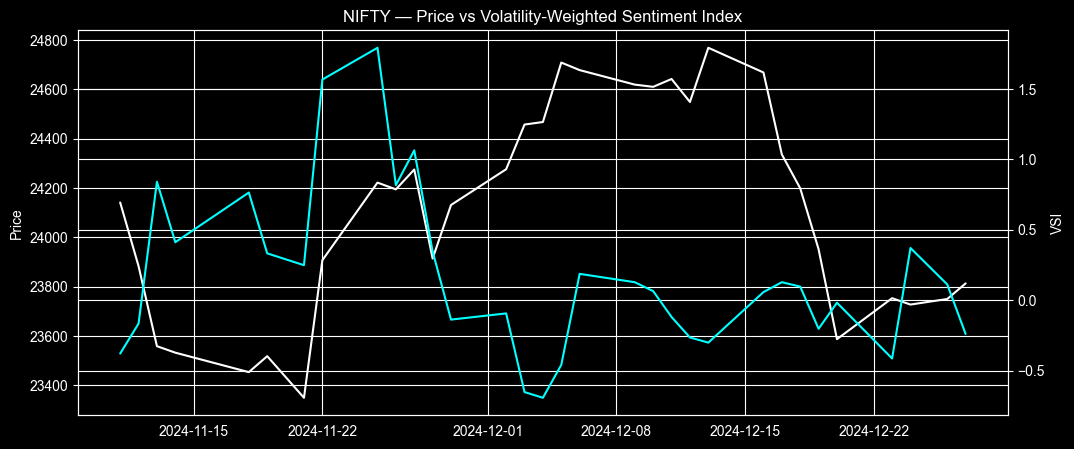

In [8]:
def plot_price_vsi(df, asset):
    fig, ax1 = plt.subplots(figsize=(12,5))

    ax1.plot(df["date"], df["close"], color="white", label="Price")
    ax1.set_ylabel("Price")

    ax2 = ax1.twinx()
    ax2.plot(df["date"], df["VSI"], color="cyan", label="VSI")
    ax2.set_ylabel("VSI")

    plt.title(f"{asset} — Price vs Volatility-Weighted Sentiment Index")
    plt.show()

plot_price_vsi(btc, "BTC")
plot_price_vsi(nifty, "NIFTY")

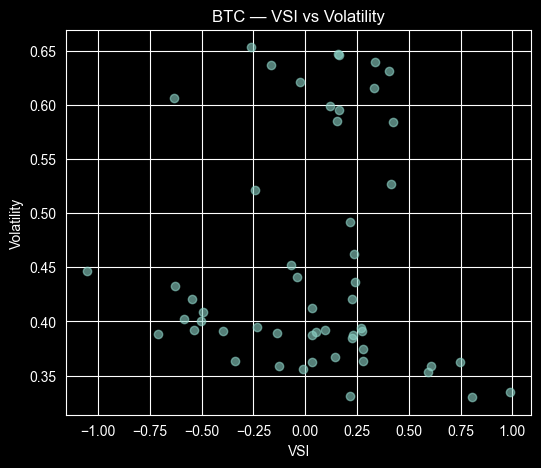

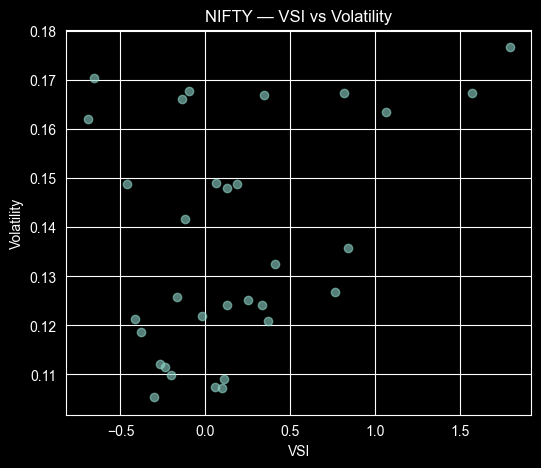

In [9]:
def plot_vsi_vol(df, asset):
    plt.figure(figsize=(6,5))
    plt.scatter(df["VSI"], df["volatility"], alpha=0.6)
    plt.xlabel("VSI")
    plt.ylabel("Volatility")
    plt.title(f"{asset} — VSI vs Volatility")
    plt.show()

plot_vsi_vol(btc, "BTC")
plot_vsi_vol(nifty, "NIFTY")

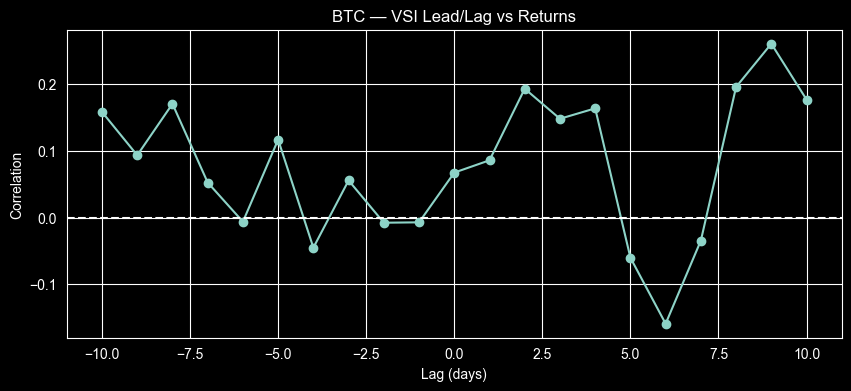

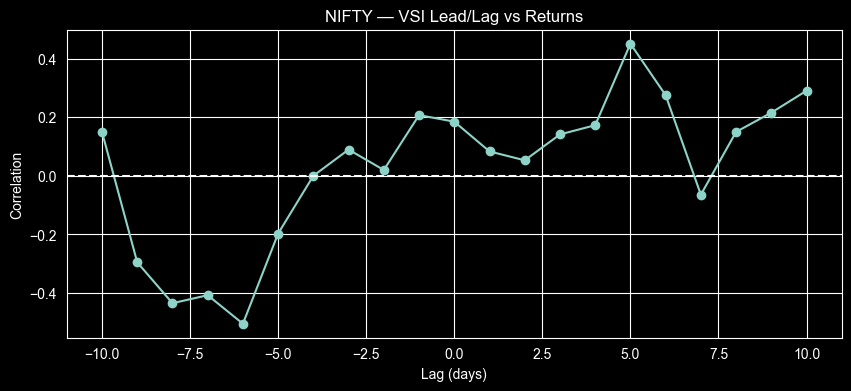

In [10]:
def vsi_lead_lag(df, asset, max_lag=10):
    lags = range(-max_lag, max_lag+1)
    corrs = []

    for lag in lags:
        corrs.append(df["VSI"].shift(lag).corr(df["return"]))

    plt.figure(figsize=(10,4))
    plt.plot(lags, corrs, marker="o")
    plt.axhline(0, color="white", linestyle="--")
    plt.title(f"{asset} — VSI Lead/Lag vs Returns")
    plt.xlabel("Lag (days)")
    plt.ylabel("Correlation")
    plt.show()

vsi_lead_lag(btc, "BTC")
vsi_lead_lag(nifty, "NIFTY")

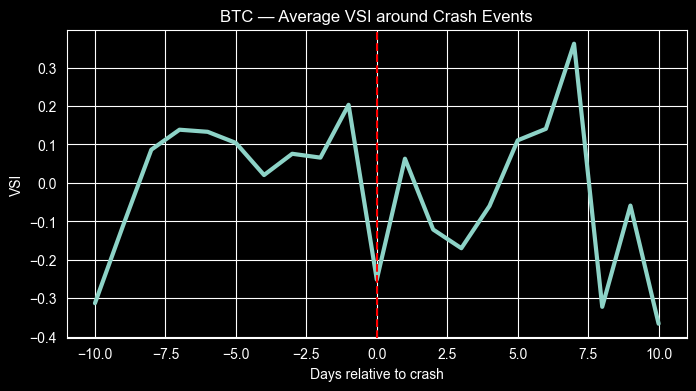

In [11]:
def vsi_stress_alignment(df, asset, threshold=-0.03, window=10):
    crash_idx = df.index[df["return"] < threshold]
    windows = []

    for i in crash_idx:
        if i-window >= 0 and i+window < len(df):
            windows.append(df["VSI"].iloc[i-window:i+window+1].values)

    avg = np.mean(windows, axis=0)

    plt.figure(figsize=(8,4))
    plt.plot(range(-window, window+1), avg, linewidth=3)
    plt.axvline(0, color="red", linestyle="--")
    plt.title(f"{asset} — Average VSI around Crash Events")
    plt.xlabel("Days relative to crash")
    plt.ylabel("VSI")
    plt.show()

vsi_stress_alignment(btc, "BTC")
#vsi_stress_alignment(nifty, "NIFTY")

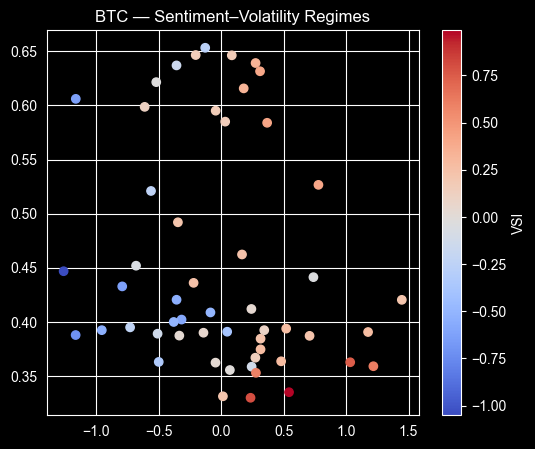

In [12]:
plt.figure(figsize=(6,5))
plt.scatter(btc["sentiment_core"], btc["volatility"], c=btc["VSI"], cmap="coolwarm")
plt.colorbar(label="VSI")
plt.title("BTC — Sentiment–Volatility Regimes")
plt.show()

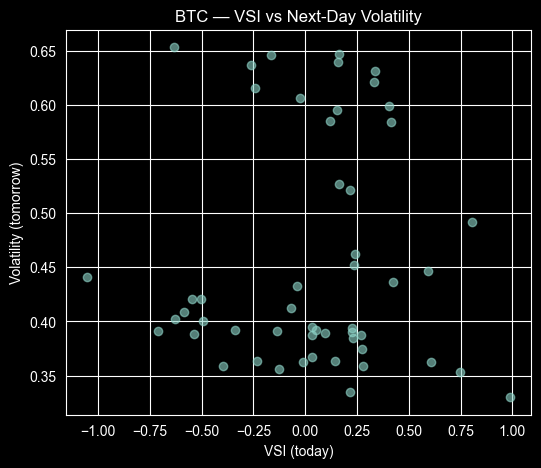

In [13]:
plt.figure(figsize=(6,5))
plt.scatter(btc["VSI"], btc["volatility"].shift(-1), alpha=0.6)
plt.xlabel("VSI (today)")
plt.ylabel("Volatility (tomorrow)")
plt.title("BTC — VSI vs Next-Day Volatility")
plt.show()

## Statistical Validation

In [14]:
def add_forward_targets(df):
    df = df.copy()
    df["ret_t1"] = df["return"].shift(-1)
    df["ret_t3"] = df["return"].shift(-3)
    df["vol_t1"] = df["volatility"].shift(-1)
    df["vol_t3"] = df["volatility"].shift(-3)
    return df.dropna()

btc_f = add_forward_targets(btc)
nifty_f = add_forward_targets(nifty)

In [15]:
from scipy.stats import pearsonr


def corr_report(df, x, y, label):
    r, p = pearsonr(df[x], df[y])
    print(f"{label}: r = {r:.3f}, p = {p:.4f}")
    return r, p

print("BTC")
corr_report(btc_f, "VSI", "ret_t1", "VSI → Return (t+1)")
corr_report(btc_f, "VSI", "ret_t3", "VSI → Return (t+3)")

print("\nNIFTY")
corr_report(nifty_f, "VSI", "ret_t1", "VSI → Return (t+1)")
corr_report(nifty_f, "VSI", "ret_t3", "VSI → Return (t+3)")

BTC
VSI → Return (t+1): r = 0.087, p = 0.5488
VSI → Return (t+3): r = 0.148, p = 0.3051

NIFTY
VSI → Return (t+1): r = 0.083, p = 0.6691
VSI → Return (t+3): r = 0.141, p = 0.4654


(np.float64(0.1410654871390748), np.float64(0.4654466792591465))

In [16]:
print("BTC")
corr_report(btc_f, "VSI", "vol_t1", "VSI → Volatility (t+1)")
corr_report(btc_f, "VSI", "vol_t3", "VSI → Volatility (t+3)")

print("\nNIFTY")
corr_report(nifty_f, "VSI", "vol_t1", "VSI → Volatility (t+1)")
corr_report(nifty_f, "VSI", "vol_t3", "VSI → Volatility (t+3)")

BTC
VSI → Volatility (t+1): r = 0.014, p = 0.9204
VSI → Volatility (t+3): r = 0.217, p = 0.1302

NIFTY
VSI → Volatility (t+1): r = 0.385, p = 0.0391
VSI → Volatility (t+3): r = 0.460, p = 0.0120


(np.float64(0.46013745266267236), np.float64(0.01201879428761729))

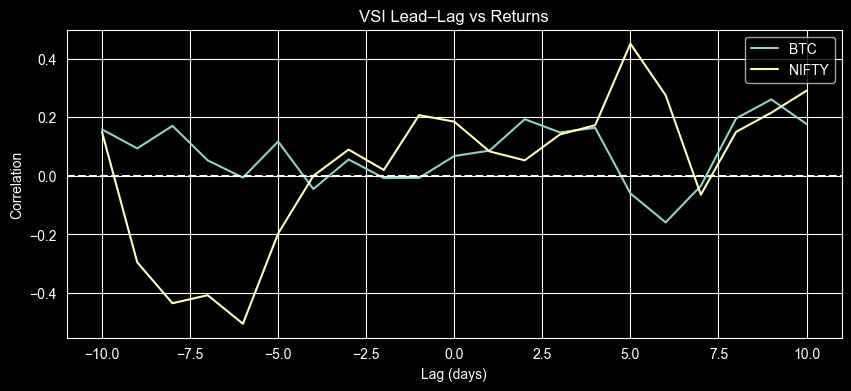

In [17]:
def lead_lag_corr(df, max_lag=10):
    lags = range(-max_lag, max_lag + 1)
    corrs = []

    for lag in lags:
        corr = df["VSI"].shift(lag).corr(df["return"])
        corrs.append(corr)

    return pd.Series(corrs, index=lags)

btc_ll = lead_lag_corr(btc)
nifty_ll = lead_lag_corr(nifty)

plt.figure(figsize=(10,4))
plt.plot(btc_ll, label="BTC")
plt.plot(nifty_ll, label="NIFTY")
plt.axhline(0, color="white", linestyle="--")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.title("VSI Lead–Lag vs Returns")
plt.legend()
plt.show()

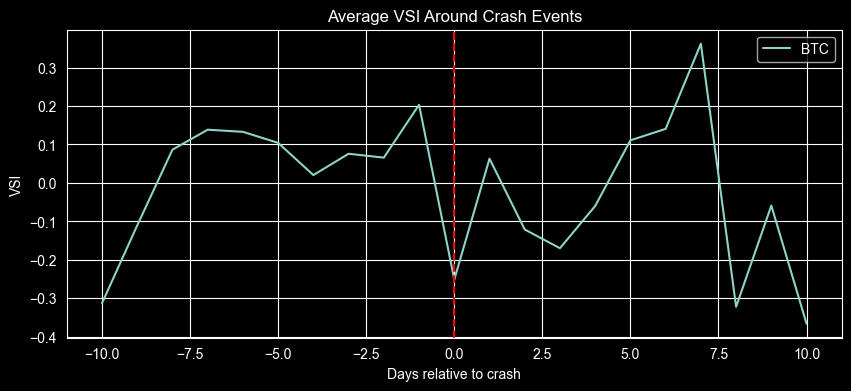

In [20]:
def event_study(df, threshold=-0.03, window=10):
    crash_idx = df.index[df["return"] < threshold]
    windows = []

    for i in crash_idx:
        if i - window < 0 or i + window >= len(df):
            continue
        windows.append(df.loc[i-window:i+window, "VSI"].values)

    return np.mean(windows, axis=0)

btc_event = event_study(btc)
#nifty_event = event_study(nifty)

x = range(-10, 11)

plt.figure(figsize=(10,4))
plt.plot(x, btc_event, label="BTC")
#plt.plot(x, nifty_event, label="NIFTY")
plt.axvline(0, color="red", linestyle="--")
plt.title("Average VSI Around Crash Events")
plt.xlabel("Days relative to crash")
plt.ylabel("VSI")
plt.legend()
plt.show()

In [21]:
print("BTC Comparison")
corr_report(btc_f, "finbert_score", "vol_t1", "FinBERT → Vol")
corr_report(btc_f, "VSI", "vol_t1", "VSI → Vol")

print("\nNIFTY Comparison")
corr_report(nifty_f, "finbert_score", "vol_t1", "FinBERT → Vol")
corr_report(nifty_f, "VSI", "vol_t1", "VSI → Vol")

BTC Comparison
FinBERT → Vol: r = -0.221, p = 0.1237
VSI → Vol: r = 0.014, p = 0.9204

NIFTY Comparison
FinBERT → Vol: r = -0.020, p = 0.9161
VSI → Vol: r = 0.385, p = 0.0391


(np.float64(0.3850742294004462), np.float64(0.039133148728403))

In [22]:
from sklearn.utils import resample


def bootstrap_corr(df, x, y, n=1000):
    stats = []
    for _ in range(n):
        sample = resample(df)
        stats.append(sample[x].corr(sample[y]))
    return np.mean(stats), np.std(stats)

mean_corr, std_corr = bootstrap_corr(btc_f, "VSI", "vol_t1")
print(f"BTC VSI→Vol bootstrap mean={mean_corr:.3f}, std={std_corr:.3f}")

BTC VSI→Vol bootstrap mean=0.013, std=0.129


## Granger Casuality Test

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import pandas as pd

In [24]:
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"{name}: ADF={result[0]:.3f}, p={result[1]:.4f}")

adf_test(btc["VSI"], "BTC VSI")
adf_test(btc["volatility"], "BTC Volatility")

adf_test(nifty["VSI"], "NIFTY VSI")
adf_test(nifty["volatility"], "NIFTY Volatility")

BTC VSI: ADF=-3.891, p=0.0021
BTC Volatility: ADF=-1.407, p=0.5790
NIFTY VSI: ADF=-2.546, p=0.1048
NIFTY Volatility: ADF=-1.332, p=0.6145


In [25]:
def prepare_granger_df(df, target, cause):
    gdf = df[[target, cause]].dropna()
    return gdf

In [26]:
def run_granger(df, target, cause, max_lag=7, name=""):
    print(f"\n{name}: {cause} → {target}")
    grangercausalitytests(
        df[[target, cause]],
        maxlag=max_lag,
        verbose=False
    )

In [30]:
def make_stationary(df, cols):
    out = df.copy()
    for c in cols:
        out[c] = out[c].diff()
    return out.dropna()

In [32]:
# BTC
btc_gc = make_stationary(btc, ["volatility"])
btc_gc["VSI"] = btc["VSI"].loc[btc_gc.index]

# NIFTY
nifty_gc = make_stationary(nifty, ["volatility", "VSI"])

adf_test(btc_gc["volatility"], "BTC Vol (diff)")
adf_test(nifty_gc["volatility"], "NIFTY Vol (diff)")
adf_test(nifty_gc["VSI"], "NIFTY VSI (diff)")

BTC Vol (diff): ADF=-8.109, p=0.0000
NIFTY Vol (diff): ADF=-4.585, p=0.0001
NIFTY VSI (diff): ADF=-6.060, p=0.0000


In [33]:
def granger_pvalues(df, target, cause, max_lag=7):
    results = {}
    test = grangercausalitytests(
        df[[target, cause]],
        maxlag=max_lag,
        verbose=False
    )
    for lag in range(1, max_lag + 1):
        p = test[lag][0]["ssr_ftest"][1]
        results[lag] = p
    return results

In [34]:
btc_p = granger_pvalues(btc_gc, "volatility", "VSI", max_lag=7)
btc_p

nifty_p = granger_pvalues(nifty_gc, "volatility", "VSI", max_lag=7)
nifty_p

E:\financial-sentiment-corr\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
E:\financial-sentiment-corr\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: np.float64(0.9533911055409242),
 2: np.float64(0.8798945108058988),
 3: np.float64(0.8426007853100839),
 4: np.float64(0.8875751133982757),
 5: np.float64(0.9039017195369752),
 6: np.float64(0.9392712879316106),
 7: np.float64(0.5923299386810298)}

In [35]:
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests

def regime_granger(df, vsi_col="VSI", vol_col="volatility",
                   q=0.8, maxlag=5, asset_name="ASSET"):

    # Drop NA and sort
    df = df[[vsi_col, vol_col]].dropna().copy()

    # Define stress regime
    threshold = df[vsi_col].quantile(q)
    stress_df = df[df[vsi_col] > threshold]

    print(f"\n{asset_name} Stress Regime (VSI > {threshold:.3f})")
    print(f"Observations: {len(stress_df)}")

    if len(stress_df) < maxlag * 5:
        print("⚠️ Not enough data points for reliable Granger test.")
        return

    data = np.column_stack([
        stress_df[vol_col].values,
        stress_df[vsi_col].values
    ])

    print("\nGranger Test: VSI → Volatility (Stress Regime)")
    grangercausalitytests(data, maxlag=maxlag, verbose=True)

regime_granger(btc, asset_name = "BTC")
regime_granger(nifty, asset_name = "NIFTY")


BTC Stress Regime (VSI > 0.280)
Observations: 11
⚠️ Not enough data points for reliable Granger test.

NIFTY Stress Regime (VSI > 0.403)
Observations: 7
⚠️ Not enough data points for reliable Granger test.


In [36]:
import statsmodels.formula.api as smf

def prepare_quantile_data(df):
    d = df[["VSI", "volatility"]].dropna().copy()
    d["vol_t1"] = d["volatility"].shift(-1)
    return d.dropna()

In [37]:
btc_q = prepare_quantile_data(btc)
nifty_q = prepare_quantile_data(nifty)

In [38]:
def quantile_regression(df, asset_name="ASSET"):
    print(f"\n{asset_name} — Quantile Regression (VSI → Next-Day Volatility)\n")

    for q in [0.5, 0.75, 0.9]:
        model = smf.quantreg("vol_t1 ~ VSI", df)
        res = model.fit(q=q)
        print(f"Quantile {q}")
        print(res.summary().tables[1])
        print("-" * 50)

In [39]:
quantile_regression(btc_q, "BTC")
quantile_regression(nifty_q, "NIFTY")


BTC — Quantile Regression (VSI → Next-Day Volatility)

Quantile 0.5
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3980      0.020     19.935      0.000       0.358       0.438
VSI           -0.0184      0.049     -0.378      0.707      -0.116       0.079
--------------------------------------------------
Quantile 0.75
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5437      0.034     16.003      0.000       0.475       0.612
VSI            0.0974      0.082      1.182      0.243      -0.068       0.263
--------------------------------------------------
Quantile 0.9
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   